# Solar Panel Readings Visualization

This notebook visualizes real-time solar panel readings from the TimescaleDB database. We'll analyze voltage, current, power, and temperature data over time.

## 🔐 Security Configuration

This notebook uses secure credential management for database access:

1. **Primary method**: Uses the app's configuration system (`app.core.config.Settings`)
2. **Fallback method**: Environment variables for database credentials
3. **No hardcoded passwords**: All sensitive information is externalized

### Environment Variables (if needed):
```bash
export TIMESCALE_HOST="your_host"
export TIMESCALE_PORT="6543"
export TIMESCALE_DATABASE="solar_monitor"
export TIMESCALE_USER="your_username" 
export TIMESCALE_PASSWORD="your_secure_password"
```

The notebook will automatically detect and use the most secure available credential source.

In [13]:
# Install required packages if not already present
import importlib
import subprocess
import sys

required_packages = [
    "pandas",
    "psycopg2-binary", 
    "matplotlib",
    "plotly",
    "sqlalchemy",
    "python-dotenv",  # Added for loading .env files
    "seaborn",
    "ipykernel",
    "nbformat"
]

missing_packages = []
for package in required_packages:
    try:
        # Handle special import names
        import_name = package
        if package == "psycopg2-binary":
            import_name = "psycopg2"
        elif package == "python-dotenv":
            import_name = "dotenv"
            
        importlib.import_module(import_name)
        print(f"✅ {package} is already installed.")
    except ImportError:
        missing_packages.append(package)

if missing_packages:
    print(f"\\n⏳ Installing missing packages: {', '.join(missing_packages)}...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", *missing_packages])
        print("✅ All missing packages installed successfully!")
        print("\\n⚠️ Please restart the kernel for the new packages to take effect if you haven't already.")
    except subprocess.CalledProcessError as e:
        print(f"❌ Error installing packages: {e}")
        print("Please install the missing packages manually and restart the kernel.")
else:
    print("\\n✅ All required packages are already installed.")

# Import necessary libraries after ensuring they are installed
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from datetime import datetime, timedelta, timezone
import time

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully")

✅ pandas is already installed.
✅ psycopg2-binary is already installed.
✅ matplotlib is already installed.
✅ plotly is already installed.
✅ sqlalchemy is already installed.
✅ python-dotenv is already installed.
✅ seaborn is already installed.
✅ ipykernel is already installed.
✅ nbformat is already installed.
\n✅ All required packages are already installed.
✅ Libraries imported successfully


In [14]:
# Load Data from TimescaleDB Database (Secure Credentials)
import os
import sys
from sqlalchemy import create_engine, text
import warnings

# Add the project path to access the config module
sys.path.append('/home/julianelliott/solar-monitor')

def get_database_config():
    """Get database configuration from environment variables or config file"""
    try:
        # Load from the .env file directly since that's where the working config is
        from dotenv import load_dotenv
        load_dotenv('/home/julianelliott/solar-monitor/config/.env')
        
        config = {
            'host': os.getenv('TIMESCALE_HOST'),
            'port': int(os.getenv('TIMESCALE_PORT', 5432)),
            'database': os.getenv('TIMESCALE_DATABASE'),
            'user': os.getenv('TIMESCALE_USER'),
            'password': os.getenv('TIMESCALE_PASSWORD')
        }
        
        if all(config.values()):
            print(f"✅ Database config loaded: {config['user']}@{config['host']}:{config['port']}/{config['database']}")
            return config
        else:
            print("❌ Missing database configuration values")
            return None
            
    except Exception as e:
        print(f"❌ Could not load database config: {e}")
        return None

# Load Data from TimescaleDB Database
def load_solar_data(hours_back=2):
    """Load solar panel readings from TimescaleDB using secure credentials"""
    
    # Get database configuration
    db_config = get_database_config()
    if not db_config:
        print("❌ Could not get database configuration")
        return None
    
    try:
        # Create SQLAlchemy engine for better pandas compatibility
        engine = create_engine(
            f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
        )
        
        # Updated SQL query to use ps100_readings table (where current data is stored)
        query = text("""
        SELECT 
            time as timestamp,
            panel_id,
            voltage,
            current,
            power,
            temperature,
            efficiency_percent as efficiency,
            conditions
        FROM ps100_readings 
        WHERE time >= NOW() - INTERVAL :hours_interval
        ORDER BY time ASC
        """)
        
        # Load data into pandas DataFrame using SQLAlchemy engine
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Suppress pandas warnings
            df = pd.read_sql_query(
                query, 
                engine, 
                params={'hours_interval': f'{hours_back} hours'}
            )
        
        # Convert timestamp to datetime and set as index
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        
        print(f"✅ Loaded {len(df)} readings from the last {hours_back} hours")
        print(f"🔐 Connected to: {db_config['user']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")
        
        if len(df) > 0:
            print(f"📊 Data from {df.index.min()} to {df.index.max()}")
            print(f"📊 Panels: {df['panel_id'].unique()}")
        
        return df
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        print("💡 Make sure the monitoring service is running and storing data to ps100_readings table")
        return None

# Load the data
df = load_solar_data(hours_back=2)
if df is not None and len(df) > 0:
    print(f"Data shape: {df.shape}")
    print(f"Time range: {df.index.min()} to {df.index.max()}")
else:
    print("⚠️ No data loaded - check connection and credentials")
    print("💡 Tip: Make sure ps100_monitor.py is running to collect data")

✅ Database config loaded: Julian-elliott@192.168.42.125:6543/solar_monitor
✅ Loaded 2175 readings from the last 2 hours
🔐 Connected to: Julian-elliott@192.168.42.125:6543/solar_monitor
📊 Data from 2025-06-11 08:59:34.537939+00:00 to 2025-06-11 09:33:48.702768+00:00
📊 Panels: ['PS100_0X40']
Data shape: (2175, 7)
Time range: 2025-06-11 08:59:34.537939+00:00 to 2025-06-11 09:33:48.702768+00:00


In [15]:
# Preview the Data
if df is not None:
    print("📊 Data Overview:")
    print("=" * 50)
    
    # Display basic info
    print(f"Number of readings: {len(df)}")
    print(f"Data collection period: {df.index.max() - df.index.min()}")
    
    # Show first few rows
    print("\n🔍 First 5 readings:")
    display(df.head())
    
    # Show basic statistics
    print("\n📈 Summary Statistics:")
    display(df.describe().round(4))
    
    # Check for any missing values
    print(f"\n🔍 Missing values: {df.isnull().sum().sum()}")
else:
    print("❌ No data available to preview")

📊 Data Overview:
Number of readings: 2175
Data collection period: 0 days 00:34:14.164829

🔍 First 5 readings:


,panel_id,voltage,current,power,temperature,efficiency,conditions
timestamp,,,,,,,
2025-06-11 08:59:34.537939+00:00,PS100_0X40,21.469141,2.588348,55.556090,27.546875,55.556090,Good - Partial sun
2025-06-11 08:59:35.539138+00:00,PS100_0X40,21.725780,2.577724,56.064453,27.539062,56.064453,Good - Partial sun
2025-06-11 08:59:36.540392+00:00,PS100_0X40,21.829884,2.584724,56.198547,27.500000,56.198547,Good - Partial sun
2025-06-11 08:59:37.542033+00:00,PS100_0X40,21.392773,2.609558,55.942870,27.531250,55.942870,Good - Partial sun
2025-06-11 08:59:38.543227+00:00,PS100_0X40,21.391407,2.614937,55.887085,27.507812,55.887085,Good - Partial sun



📈 Summary Statistics:


,voltage,current,power,temperature,efficiency
count,2175.0000,2175.0000,2175.0000,2175.0000,2175.0000
mean,21.6701,3.2342,70.1076,29.9485,70.1076
std,0.5278,0.2817,6.4973,1.2742,6.4973
min,18.8217,2.0680,41.5750,27.0703,41.5750
25%,21.4870,3.2674,71.7625,29.3242,71.7625
50%,21.7209,3.3392,72.4311,30.4688,72.4311
75%,21.9283,3.3820,73.2869,30.9531,73.2869
max,23.4141,3.6690,80.1584,31.1484,80.1584



🔍 Missing values: 0


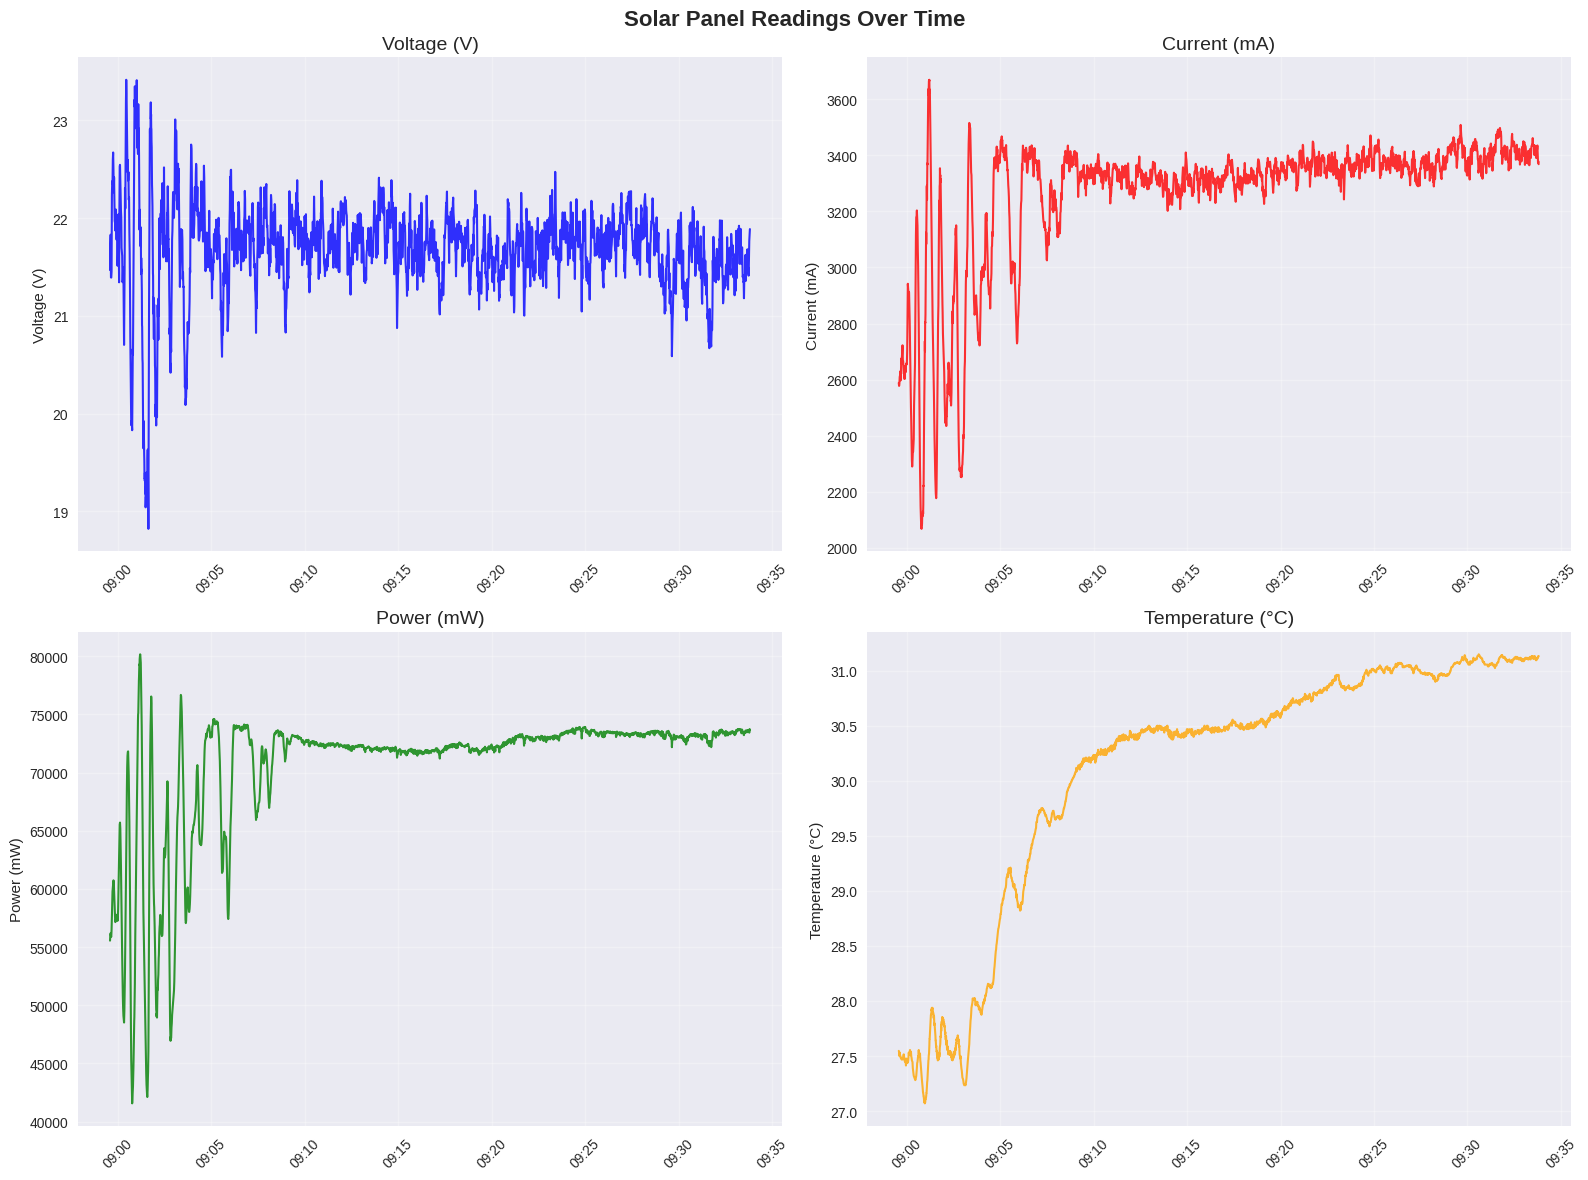

In [16]:
# Visualize the Data with Matplotlib
if df is not None and len(df) > 0:
    
    # Create subplots for different metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Solar Panel Readings Over Time', fontsize=16, fontweight='bold')
    
    # 1. Voltage over time
    axes[0, 0].plot(df.index, df['voltage'], color='blue', linewidth=1.5, alpha=0.8)
    axes[0, 0].set_title('Voltage (V)', fontsize=14)
    axes[0, 0].set_ylabel('Voltage (V)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # 2. Current over time
    axes[0, 1].plot(df.index, df['current'] * 1000, color='red', linewidth=1.5, alpha=0.8)  # Convert to mA
    axes[0, 1].set_title('Current (mA)', fontsize=14)
    axes[0, 1].set_ylabel('Current (mA)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # 3. Power over time
    axes[1, 0].plot(df.index, df['power'] * 1000, color='green', linewidth=1.5, alpha=0.8)  # Convert to mW
    axes[1, 0].set_title('Power (mW)', fontsize=14)
    axes[1, 0].set_ylabel('Power (mW)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # 4. Temperature over time
    axes[1, 1].plot(df.index, df['temperature'], color='orange', linewidth=1.5, alpha=0.8)
    axes[1, 1].set_title('Temperature (°C)', fontsize=14)
    axes[1, 1].set_ylabel('Temperature (°C)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Rotate x-axis labels for better readability
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No data available for visualization")

In [17]:
# Interactive Plotly Visualization
if df is not None and len(df) > 0:
    
    # Create subplots with Plotly
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Voltage (V)', 'Current (mA)', 'Power (mW)', 'Temperature (°C)'),
        vertical_spacing=0.1,
        horizontal_spacing=0.1
    )
    
    # Add voltage trace
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['voltage'],
            mode='lines',
            name='Voltage',
            line=dict(color='blue', width=2),
            hovertemplate='Time: %{x}<br>Voltage: %{y:.3f} V<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add current trace (in mA)
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['current'] * 1000,
            mode='lines',
            name='Current',
            line=dict(color='red', width=2),
            hovertemplate='Time: %{x}<br>Current: %{y:.3f} mA<extra></extra>'
        ),
        row=1, col=2
    )
    
    # Add power trace (in mW)
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['power'] * 1000,
            mode='lines',
            name='Power',
            line=dict(color='green', width=2),
            hovertemplate='Time: %{x}<br>Power: %{y:.3f} mW<extra></extra>'
        ),
        row=2, col=1
    )
    
    # Add temperature trace
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['temperature'],
            mode='lines',
            name='Temperature',
            line=dict(color='orange', width=2),
            hovertemplate='Time: %{x}<br>Temperature: %{y:.1f} °C<extra></extra>'
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title='Real-Time Solar Panel Monitoring Dashboard',
        title_x=0.5,
        height=700,
        showlegend=False,
        hovermode='x unified'
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Time", row=2, col=1)
    fig.update_xaxes(title_text="Time", row=2, col=2)
    fig.update_yaxes(title_text="Voltage (V)", row=1, col=1)
    fig.update_yaxes(title_text="Current (mA)", row=1, col=2)
    fig.update_yaxes(title_text="Power (mW)", row=2, col=1)
    fig.update_yaxes(title_text="Temperature (°C)", row=2, col=2)
    
    fig.show()
    
else:
    print("❌ No data available for interactive visualization")
# Ensure nbformat is installed for Plotly rendering
%pip install --quiet nbformat>=4.2.0

# Interactive Plotly Visualization
if df is not None and len(df) > 0:
    
    # Create subplots with Plotly
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Voltage (V)', 'Current (mA)', 'Power (mW)', 'Temperature (°C)'),
        vertical_spacing=0.1,
        horizontal_spacing=0.1
    )
    
    # Add voltage trace
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['voltage'],
            mode='lines',
            name='Voltage',
            line=dict(color='blue', width=2),
            hovertemplate='Time: %{x}<br>Voltage: %{y:.3f} V<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add current trace (in mA)
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['current'] * 1000,
            mode='lines',
            name='Current',
            line=dict(color='red', width=2),
            hovertemplate='Time: %{x}<br>Current: %{y:.3f} mA<extra></extra>'
        ),
        row=1, col=2
    )

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Real-Time Data Analysis and Statistics
if df is not None and len(df) > 0:
    
    print("📊 Real-Time Solar Panel Analysis")
    print("=" * 50)
    
    # Current status (latest reading)
    latest = df.iloc[-1]
    latest_time = df.index[-1]
    
    print(f"🕐 Latest Reading Time: {latest_time.strftime('%Y-%m-%d %H:%M:%S UTC')}")
    print(f"⚡ Current Power: {latest['power']*1000:.2f} mW")
    print(f"🔋 Current Voltage: {latest['voltage']:.3f} V")
    print(f"⚡ Current Flow: {latest['current']*1000:.3f} mA")
    print(f"🌡️  Temperature: {latest['temperature']:.1f} °C")
    print(f"📈 Efficiency: {latest['efficiency']:.6f}")
    print(f"☀️ Conditions: {latest['conditions']}")
    
    # Calculate some statistics
    print(f"\n📈 Last 2 Hours Statistics:")
    print(f"   Average Power: {df['power'].mean()*1000:.2f} mW")
    print(f"   Max Power: {df['power'].max()*1000:.2f} mW")
    print(f"   Min Power: {df['power'].min()*1000:.2f} mW")
    print(f"   Power Std Dev: {df['power'].std()*1000:.3f} mW")
    print(f"   Temperature Range: {df['temperature'].min():.1f}°C - {df['temperature'].max():.1f}°C")
    
    # Data collection rate
    time_diff = (df.index[-1] - df.index[0]).total_seconds()
    readings_per_second = len(df) / time_diff if time_diff > 0 else 0
    print(f"   Data Collection Rate: {readings_per_second:.2f} readings/second")
    
    # Power trend (simple)
    if len(df) >= 10:
        recent_power = df['power'].tail(10).mean()
        older_power = df['power'].head(10).mean()
        trend = "📈 Increasing" if recent_power > older_power else "📉 Decreasing" if recent_power < older_power else "➡️ Stable"
        print(f"   Power Trend: {trend}")
    
else:
    print("❌ No data available for analysis")

📊 Real-Time Solar Panel Analysis
🕐 Latest Reading Time: 2025-06-11 09:33:48 UTC
⚡ Current Power: 73663.76 mW
🔋 Current Voltage: 21.887 V
⚡ Current Flow: 3368.149 mA
🌡️  Temperature: 31.1 °C
📈 Efficiency: 73.663760
☀️ Conditions: Good - Partial sun

📈 Last 2 Hours Statistics:
   Average Power: 70107.62 mW
   Max Power: 80158.45 mW
   Min Power: 41574.95 mW
   Power Std Dev: 6497.288 mW
   Temperature Range: 27.1°C - 31.1°C
   Data Collection Rate: 1.06 readings/second
   Power Trend: 📈 Increasing


🔄 Refreshing data...
✅ Database config loaded: Julian-elliott@192.168.42.125:6543/solar_monitor
✅ Loaded 599 readings from the last 0.16666666666666666 hours
🔐 Connected to: Julian-elliott@192.168.42.125:6543/solar_monitor
📊 Data from 2025-06-11 09:23:51.759674+00:00 to 2025-06-11 09:33:50.705980+00:00
📊 Panels: ['PS100_0X40']
🔄 Refreshed data - 599 readings from last 10 minutes

📊 Latest 10 Readings:
✅ Database config loaded: Julian-elliott@192.168.42.125:6543/solar_monitor
✅ Loaded 599 readings from the last 0.16666666666666666 hours
🔐 Connected to: Julian-elliott@192.168.42.125:6543/solar_monitor
📊 Data from 2025-06-11 09:23:51.759674+00:00 to 2025-06-11 09:33:50.705980+00:00
📊 Panels: ['PS100_0X40']
🔄 Refreshed data - 599 readings from last 10 minutes

📊 Latest 10 Readings:


,Voltage (V),Current (mA),Power (mW),Temp (°C)
timestamp,,,,
2025-06-11 09:33:41.693144+00:00,21.501,3421.383,73496.216,31.109
2025-06-11 09:33:42.694266+00:00,21.444,3430.595,73542.660,31.109
2025-06-11 09:33:43.695523+00:00,21.493,3420.734,73603.210,31.102
2025-06-11 09:33:44.697223+00:00,21.411,3434.753,73572.815,31.117
2025-06-11 09:33:45.698551+00:00,21.588,3405.685,73657.230,31.117
2025-06-11 09:33:46.699666+00:00,21.766,3373.470,73428.280,31.117
2025-06-11 09:33:47.700819+00:00,21.825,3378.487,73735.410,31.133
2025-06-11 09:33:48.702768+00:00,21.887,3368.149,73663.760,31.133
2025-06-11 09:33:49.704250+00:00,21.912,3373.394,73580.140,31.133


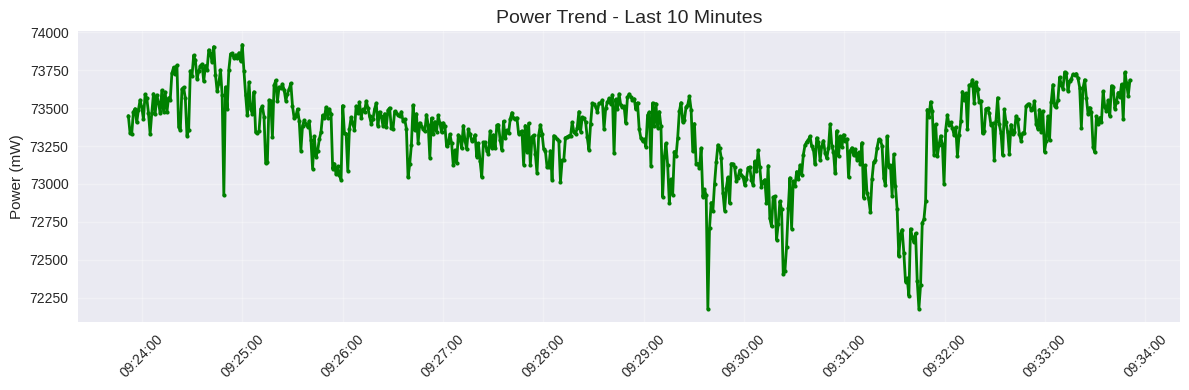

In [19]:
import matplotlib.dates as mdates

# Live Data Refresh (Run this cell to get the latest data)
def refresh_and_show_latest(minutes_back=10):
    """Refresh data and show latest readings using secure credentials"""
    
    # Load fresh data using the secure credential function
    fresh_df = load_solar_data(hours_back=minutes_back/60)
    
    if fresh_df is not None and len(fresh_df) > 0:
        print(f"🔄 Refreshed data - {len(fresh_df)} readings from last {minutes_back} minutes")
        
        # Show latest 10 readings
        print("\n📊 Latest 10 Readings:")
        latest_10 = fresh_df.tail(10)[['voltage', 'current', 'power', 'temperature']].copy()
        latest_10['current_ma'] = latest_10['current'] * 1000
        latest_10['power_mw'] = latest_10['power'] * 1000
        latest_10 = latest_10[['voltage', 'current_ma', 'power_mw', 'temperature']]
        latest_10.columns = ['Voltage (V)', 'Current (mA)', 'Power (mW)', 'Temp (°C)']
        
        display(latest_10.round(3))
        
        # Quick trend plot of last few minutes
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        ax.plot(fresh_df.index, fresh_df['power'] * 1000, 'g-', linewidth=2, marker='o', markersize=3)
        ax.set_title(f'Power Trend - Last {minutes_back} Minutes', fontsize=14)
        ax.set_ylabel('Power (mW)')
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return fresh_df
    else:
        print("❌ No fresh data available")
        return None

# Run the refresh
print("🔄 Refreshing data...")
current_df = refresh_and_show_latest(minutes_back=10)

In [20]:
# 🔄 Live Data Monitoring
# Run this cell to get the latest readings and check monitoring status

def get_latest_readings(limit=10):
    """Get the most recent readings from the database"""
    db_config = get_database_config()
    if not db_config:
        return None
    
    try:
        engine = create_engine(
            f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
        )
        
        query = text("""
        SELECT 
            time as timestamp,
            panel_id,
            voltage,
            current,
            power,
            temperature,
            conditions
        FROM ps100_readings 
        ORDER BY time DESC 
        LIMIT :limit
        """)
        
        df_latest = pd.read_sql_query(query, engine, params={'limit': limit})
        df_latest['timestamp'] = pd.to_datetime(df_latest['timestamp'])
        
        return df_latest
        
    except Exception as e:
        print(f"❌ Error getting latest readings: {e}")
        return None

# Get current status
print("🔄 Getting latest solar panel data...")
current_df = get_latest_readings(10)

if current_df is not None and len(current_df) > 0:
    latest = current_df.iloc[0]
    
    print("=" * 60)
    print(f"📊 CURRENT SOLAR PANEL STATUS")
    print("=" * 60)
    print(f"🕐 Last Reading: {latest['timestamp']}")
    print(f"🏷️  Panel ID: {latest['panel_id']}")
    print(f"⚡ Power: {latest['power']:.1f}W")
    print(f"🔋 Voltage: {latest['voltage']:.1f}V") 
    print(f"🔌 Current: {latest['current']:.2f}A")
    print(f"🌡️  Temperature: {latest['temperature']:.1f}°C")
    print(f"☀️  Conditions: {latest['conditions']}")
    
    # Check how recent the data is
    latest_time = pd.to_datetime(latest['timestamp'])
    now = datetime.now(timezone.utc)
    age_seconds = (now - latest_time.tz_convert('UTC')).total_seconds()
    
    if age_seconds < 10:
        print(f"✅ Data is LIVE (updated {age_seconds:.0f} seconds ago)")
    elif age_seconds < 60:
        print(f"⚠️  Data is {age_seconds:.0f} seconds old")
    else:
        print(f"❌ Data is {age_seconds/60:.1f} minutes old - check if monitoring is running")
    
    print("=" * 60)
    
    # Show last 5 readings
    print("\\n📈 Last 5 readings:")
    display(current_df[['timestamp', 'power', 'voltage', 'current', 'temperature', 'conditions']].head())
    
else:
    print("❌ No current data available")
    print("💡 Make sure ps100_monitor.py is running to collect data")

🔄 Getting latest solar panel data...
✅ Database config loaded: Julian-elliott@192.168.42.125:6543/solar_monitor
📊 CURRENT SOLAR PANEL STATUS
🕐 Last Reading: 2025-06-11 09:33:51.707435+00:00
🏷️  Panel ID: PS100_0X40
⚡ Power: 73.7W
🔋 Voltage: 21.7V
🔌 Current: 3.40A
🌡️  Temperature: 31.1°C
☀️  Conditions: Good - Partial sun
✅ Data is LIVE (updated 0 seconds ago)
\n📈 Last 5 readings:


,timestamp,power,voltage,current,temperature,conditions
0,2025-06-11 09:33:51.707435+00:00,73.66510,21.656445,3.402424,31.117188,Good - Partial sun
1,2025-06-11 09:33:50.705980+00:00,73.68561,21.722656,3.392200,31.125000,Good - Partial sun
2,2025-06-11 09:33:49.704250+00:00,73.58014,21.911524,3.373394,31.132812,Good - Partial sun
3,2025-06-11 09:33:48.702768+00:00,73.66376,21.887110,3.368149,31.132812,Good - Partial sun
4,2025-06-11 09:33:47.700819+00:00,73.73541,21.825000,3.378487,31.132812,Good - Partial sun
